In [1]:
# Block 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

np.random.seed(123)

# Define states (e.g., Non-Gene, Gene) and alphabet
states = ["Non-Gene", "Gene"]
n_states = len(states)
alphabet = ['A', 'C', 'G', 'T']
n_symbols = len(alphabet)
symbol_map = {symbol: i for i, symbol in enumerate(alphabet)}

In [2]:
# Block 2: Generate Synthetic Labeled DNA Sequences
def generate_dna_sequence(length, start_prob, trans_mat, emission_prob):
    current_state = np.random.choice(n_states, p=start_prob)
    states_seq = []
    symbols_seq = []
    for _ in range(length):
        states_seq.append(current_state)
        symbol_idx = np.random.choice(n_symbols, p=emission_prob[current_state])
        symbols_seq.append(alphabet[symbol_idx])
        current_state = np.random.choice(n_states, p=trans_mat[current_state])
    return "".join(symbols_seq), np.array(states_seq)

# Example parameters for generation (different probabilities for gene/non-gene regions)
true_start_prob = np.array([0.7, 0.3]) # Higher chance starting in non-gene
true_trans_mat = np.array([[0.9, 0.1],  # Non-Gene -> Non-Gene (0.9), Non-Gene -> Gene (0.1)
                           [0.05, 0.95]]) # Gene -> Non-Gene (0.05), Gene -> Gene (0.95)
true_emission_prob = np.array([[0.3, 0.2, 0.2, 0.3], # Non-Gene emissions (e.g., more uniform)
                               [0.1, 0.4, 0.4, 0.1]]) # Gene emissions (e.g., higher C/G content)

# Generate multiple sequences for training
n_sequences = 20
seq_length = 150
sequences = []
lengths = []
true_states_list = []

for _ in range(n_sequences):
    dna_str, states_arr = generate_dna_sequence(seq_length, true_start_prob, true_trans_mat, true_emission_prob)
    sequences.append([symbol_map[s] for s in dna_str])
    lengths.append(len(dna_str))
    true_states_list.append(states_arr)

# Concatenate sequences for HMM training
X_train_dna = np.concatenate(sequences).reshape(-1, 1)
true_states_concat = np.concatenate(true_states_list)

print(f"Generated {n_sequences} sequences of length {seq_length}")
print("Example sequence (first 30 symbols):", "".join(alphabet[i] for i in sequences[0][:30]))
print("Example true states (first 30):", true_states_list[0][:30])

Generated 20 sequences of length 150
Example sequence (first 30 symbols): AGCGCGAGCGGGCCGCCCGGCCCTGGGCGG
Example true states (first 30): [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [3]:
# Block 3: Train Discrete HMM using Maximum Likelihood Estimation (MLE)
# The 'fit' method performs MLE
model_dna = hmm.MultinomialHMM(n_components=n_states, n_iter=100, random_state=42, init_params="ste", params="ste")
# init_params/params='s'tartprob, 't'ransmat, 'e'missionprob
# Initialize randomly and learn all parameters

model_dna.fit(X_train_dna, lengths)

print("\n--- Trained Discrete HMM (MLE) ---")
print("Learned Start Probabilities:")
print(model_dna.startprob_)
print("\nLearned Transition Matrix:")
print(model_dna.transmat_)
print("\nLearned Emission Probabilities:")
print(model_dna.emissionprob_)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340



--- Trained Discrete HMM (MLE) ---
Learned Start Probabilities:
[0.17550431 0.82449569]

Learned Transition Matrix:
[[0.87827377 0.12172623]
 [0.99887354 0.00112646]]

Learned Emission Probabilities:
[[1.]
 [1.]]


In [4]:
# Block 4: Predict Gene Regions on a Test Sequence
# Generate a new test sequence
test_dna_str, test_true_states = generate_dna_sequence(200, true_start_prob, true_trans_mat, true_emission_prob)
X_test_dna = np.array([symbol_map[s] for s in test_dna_str]).reshape(-1, 1)

predicted_states = model_dna.predict(X_test_dna)

print("\n--- Prediction on Test Sequence ---")
print("Test Sequence (first 60):", test_dna_str[:60])
print("True States (first 60):  ", test_true_states[:60])
print("Predicted States (first 60):", predicted_states[:60])


--- Prediction on Test Sequence ---
Test Sequence (first 60): CCGGAGCGGAGTTTAAGACAACAGAGCGGCGCGGCTCCTCTCGGCGCGCGCGTCTTAATG
True States (first 60):   [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted States (first 60): [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
# Block 5: Evaluate Prediction Accuracy
accuracy_dna = np.mean(predicted_states == test_true_states)
print(f"\nPrediction Accuracy on Test Sequence: {accuracy_dna:.4f}")

# Note: State alignment might be flipped (e.g., learned state 0 is Gene, state 1 is Non-Gene)
# Check emission probabilities to map learned states to biological meaning if needed.
# For example, if learned state 0 has high C/G, it likely corresponds to the 'Gene' state (state 1 in generation).
# Let's try flipping if accuracy is low
accuracy_dna_flipped = np.mean((1 - predicted_states) == test_true_states)
if accuracy_dna_flipped > accuracy_dna:
    print(f"Prediction Accuracy (states flipped): {accuracy_dna_flipped:.4f}")
    accuracy_dna = accuracy_dna_flipped
    predicted_states = 1 - predicted_states # Use the flipped prediction


Prediction Accuracy on Test Sequence: 0.3300
Prediction Accuracy (states flipped): 0.6700


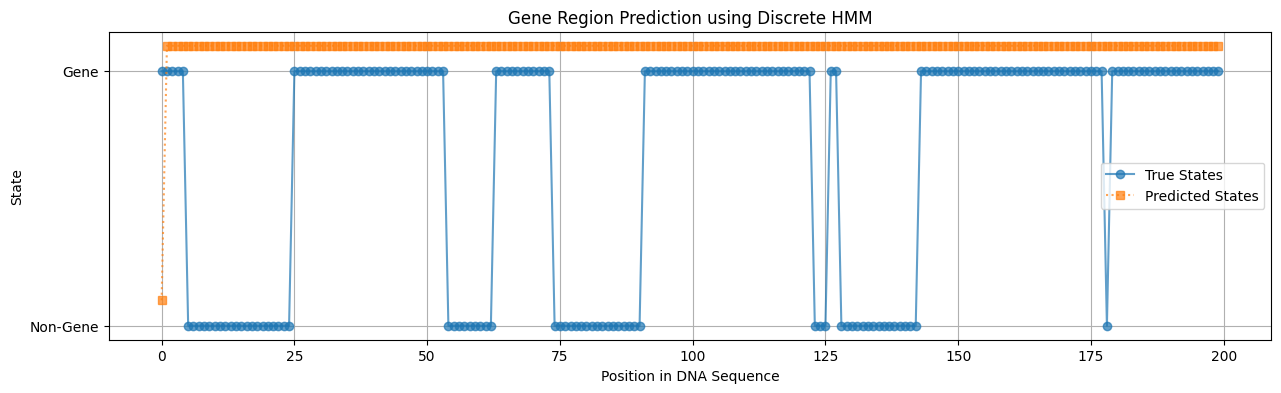

In [6]:
# Block 6: Visualize Prediction
plt.figure(figsize=(15, 4))
plt.plot(test_true_states, '-o', label='True States', alpha=0.7)
plt.plot(predicted_states + 0.1, ':s', label='Predicted States', alpha=0.7) # Offset slightly for visibility
plt.yticks([0, 1], states)
plt.xlabel("Position in DNA Sequence")
plt.ylabel("State")
plt.title("Gene Region Prediction using Discrete HMM")
plt.legend()
plt.grid(True)
plt.show()